In [1]:
import pandas as pd
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm

import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from shapely.geometry import Polygon, MultiPolygon
from pyresample import geometry, load_area

# Get lon lats from filenames

In [2]:
mydir = "/home/ingrid/Documents/Exjobb/rain_gauge_data/csv_formatado/"
filename_list = os.listdir(mydir)
print(len(filename_list))

609


In [3]:
filename_list

['RS_A831_124_W56.43722221_S30.3686111.csv',
 'MA_A204_254_W46.02749999_S7.45527777.csv',
 'MA_A219_41_W45.37277777_S1.66166666.csv',
 'MT_A914_260_W57.52666666_S11.28027777.csv',
 'PI_A336_270_W43.86472222_S8.44305555.csv',
 'MS_A710_424_W51.18138888_S19.69527777.csv',
 'PA_A240_116_W49.37916666_S5.16722221.csv',
 'PA_A229_148_W49.67499999_S3.82277777.csv',
 'PI_A331_235_W42.25083333_S8.36472222.csv',
 'TO_A039_220_W49.60833333_S11.98722221.csv',
 'DF_A046_990_W48.13749999_S15.93527777.csv',
 'MT_A901_240_W56.72944443_S15.55916666.csv',
 'PI_A354_156_W42.14694444_S6.97416666.csv',
 'AM_S121_F_W65.01749999_S.41444444.csv',
 'TO_A055_178_W49.84777777_S10.80833333.csv',
 'MT_A941_116_W57.69277777_S16.07444443.csv',
 'BA_A402_470.37_W45.01666666_S12.15.csv',
 'SE_A420_308_W37.74722221_S10.39944444.csv',
 'BA_A414_874.81_W40.80138888_S14.8861111.csv',
 'PA_A248_81_W47.0575_S1.73472221.csv',
 'MT_A919_261_W58.57194443_S9.90611111.csv',
 'SP_A736_525_W48.84027777_S21.13305554.csv',
 'SC_A816

In [4]:
def extractLonLat(filename):
    lonlat = filename.split("W")[1][:-4].split("_S")
    lon = -float(lonlat[0])
    lat = -float(lonlat[1])
    return(lon, lat)

In [5]:
lons = []
lats = []
for filename in filename_list:
    lon, lat = extractLonLat(filename)
    lons.append(lon)
    lats.append(lat)

In [6]:
d = {'lon': lons, 'lat': lats}
lonlats_df = pd.DataFrame(data=d)

In [7]:
print(lonlats_df)

           lon        lat
0   -56.437222 -30.368611
1   -46.027500  -7.455278
2   -45.372778  -1.661667
3   -57.526667 -11.280278
4   -43.864722  -8.443056
..         ...        ...
604 -43.184167 -13.416667
605 -41.106944 -20.104167
606 -50.425278 -16.945833
607 -49.274167  -8.259167
608 -54.381111 -15.580000

[609 rows x 2 columns]


In [7]:
lonlats_df.to_pickle('../reference/rain_gauge_locs.pckl')

# Example

In [8]:
filename = filename_list[0]
lon, lat = extractLonLat(filename)
print(lon, lat)

-56.43722221 -30.3686111


In [9]:
df = pd.read_csv(mydir+filename_list[0], delimiter = ',', header=0)
print(df.tail()) 

        DATA_UTC   00   01   02   03   04   05   06   07   08  ...   14   15  \
4820  2020-12-27  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4821  2020-12-28  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4822  2020-12-29  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4823  2020-12-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4824  2020-12-31  0.0  0.4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

       16   17   18   19   20   21   22   23  
4820  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4821  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4822  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4823  0.0  0.0  0.0  2.6  0.2  0.0  0.8  1.2  
4824  0.0  NaN  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 25 columns]


# Check amount of nans in relevant data

In [57]:
num_nans_list = []
num_tots_list = []
for month in range(4,13):
    print(month)
    num_nans = 0
    num_tots = 0
    st = '2020-'+str(month)+'-1'
    et = '2020-'+str(month+1)+'-1'
    if month >= 12:
        et = '2021-'+str(month+1-12)+'-1'
    print(st)
    print(et)
    for f in filename_list:
        #print(f)
        df = pd.read_csv(mydir+f, delimiter = ',', header=0)
        df.DATA_UTC = pd.to_datetime(df.DATA_UTC, format='%Y-%m-%d')
        mask = (df.DATA_UTC >= st)*(df.DATA_UTC < et)
        nf = df.loc[mask]
        num_nans += nf.isnull().values.sum()
        num_tots += nf.shape[0]*24
    num_nans_list.append(num_nans)
    num_tots_list.append(num_tots)


4
2020-4-1
2020-5-1
5
2020-5-1
2020-6-1
6
2020-6-1
2020-7-1
7
2020-7-1
2020-8-1
8
2020-8-1
2020-9-1
9
2020-9-1
2020-10-1
10
2020-10-1
2020-11-1
11
2020-11-1
2020-12-1
12
2020-12-1
2021-1-1


In [50]:
print(num_nans_list)
print(num_tots_list)
print([n/t for n,t in zip(num_nans_list, num_tots_list)])
print([t-n for n,t in zip(num_nans_list, num_tots_list)])

[112841, 135711, 122271, 133268, 139969, 144248, 169328, 183473, 151323]
[423360, 437472, 423360, 437472, 437472, 423360, 437472, 423360, 437472]
[0.266536753590325, 0.3102164252797893, 0.2888109410430839, 0.3046320678809158, 0.31994961963279933, 0.34072184429327285, 0.3870602004242557, 0.4333734882842026, 0.3459032806671056]
[310519, 301761, 301089, 304204, 297503, 279112, 268144, 239887, 286149]


# Check specific events

In [10]:
#mydate = ['2020-07-06', '2020-07-08'] # Rio Grande do Sul
#mydate = ['2020-11-02', '2020-11-03'] # Sanharo in Pernambuco
#mydate = ['2020-12-16', '2020-12-18'] # Presidente Getúlio
mydate = ['2020-12-22', '2020-12-23'] # Xerém (BEST)
#mydate = ['2020-03-03', '2020-03-03'] # Guarujá
#mydate = ['2020-11-26', '2020-11-26'] # Sao Carlos

In [11]:
#lonlats_mask = (lonlats_df['lon'] < -53)*(lonlats_df['lon'] > -55)*(lonlats_df['lat'] < -28)*(lonlats_df['lat'] > -30)
#lonlats_mask = (lonlats_df['lon'] < -35.5)*(lonlats_df['lon'] > -37.5)*(lonlats_df['lat'] < -7.5)*(lonlats_df['lat'] > -9.5)
#lonlats_mask = (lonlats_df['lon'] < -48.5)*(lonlats_df['lon'] > -50.5)*(lonlats_df['lat'] < -26)*(lonlats_df['lat'] > -27.5)
lonlats_mask = (lonlats_df['lon'] < -43)*(lonlats_df['lon'] > -43.5)*(lonlats_df['lat'] < -22)*(lonlats_df['lat'] > -23)
#lonlats_mask = (lonlats_df['lon'] < -46)*(lonlats_df['lon'] > -46.6)*(lonlats_df['lat'] < -23)*(lonlats_df['lat'] > -24.5)
#lonlats_mask = (lonlats_df['lon'] < -47)*(lonlats_df['lon'] > -48)*(lonlats_df['lat'] < -22)*(lonlats_df['lat'] > -23)

/home/ingrid/anaconda3/envs/geostat/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/ingrid/anaconda3/envs/geostat/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/ingrid/anaconda3/envs/geostat/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


In [12]:
lonlats_inds = lonlats_df[lonlats_mask].index
print(lonlats_inds)
print(lonlats_df[lonlats_mask])

Int64Index([60, 290, 365, 382, 391, 417, 517], dtype='int64')
           lon        lat
60  -43.411111 -22.860833
290 -43.402778 -22.939722
365 -43.291389 -22.481667
382 -43.190278 -22.988333
391 -43.282222 -22.589722
417 -43.208611 -22.098333
517 -43.101944 -22.867500


In [13]:
for i in lonlats_inds:
    print('\n', i)
    myfile = filename_list[i]
    print(myfile)
    df = pd.read_csv(mydir+myfile, delimiter = ',', header=0)
    df.DATA_UTC = pd.to_datetime(df.DATA_UTC, format='%Y-%m-%d')
    mask = (df.DATA_UTC >= mydate[0])*(df.DATA_UTC <= mydate[1])
    print(df.loc[mask].T)


 60
RJ_A621_45_W43.41111111_S22.86083333.csv
                         5002                 5003
DATA_UTC  2020-12-22 00:00:00  2020-12-23 00:00:00
00                        0.0                  0.0
01                        0.0                  0.0
02                        0.0                  0.0
03                        0.0                  0.0
04                        0.0                  0.2
05                        0.0                  0.0
06                        0.0                  0.0
07                        0.0                  0.0
08                        0.0                  0.0
09                        0.0                  0.0
10                        0.0                  0.0
11                        0.0                  0.0
12                        0.4                  0.0
13                        0.2                  0.0
14                        0.0                  0.0
15                        0.0                  0.0
16                        0.0       

/home/ingrid/anaconda3/envs/geostat/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/ingrid/anaconda3/envs/geostat/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/ingrid/anaconda3/envs/geostat/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(
/home/ingrid/anaconda3/envs/geostat/lib/python3.8/site-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
 

/home/ingrid/anaconda3/envs/geostat/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/ingrid/anaconda3/envs/geostat/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


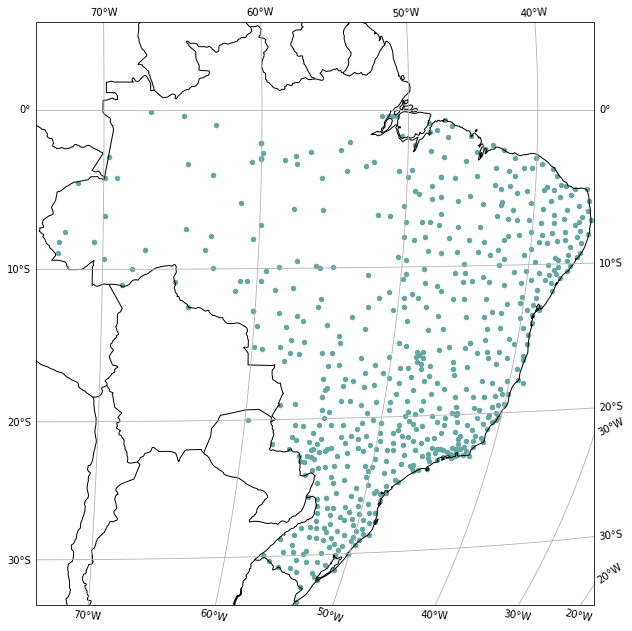

In [13]:
import sys
sys.path.append('../visualize')
import plot_dataset_funs
from plot_dataset_funs import initial_load

areas_filepath =  '../dataset/downloads/files/areas.yaml'
initial_load(areas_filepath)
area_def_region = plot_dataset_funs.area_def.copy(area_extent = plot_dataset_funs.region_corners,
                                                  height = plot_dataset_funs.region_height, 
                                                  width = plot_dataset_funs.region_width)
crs = area_def_region.to_cartopy_crs()
fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize = (10,11))

ax.scatter(x=lonlats_df.lon, y=lonlats_df.lat, transform=ccrs.PlateCarree(), s=20, color='#64a6a1')

ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cartopy.feature.BORDERS)
ax.set_global()
#ax.title.set_text(plot_title)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

/home/ingrid/anaconda3/envs/geostat/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


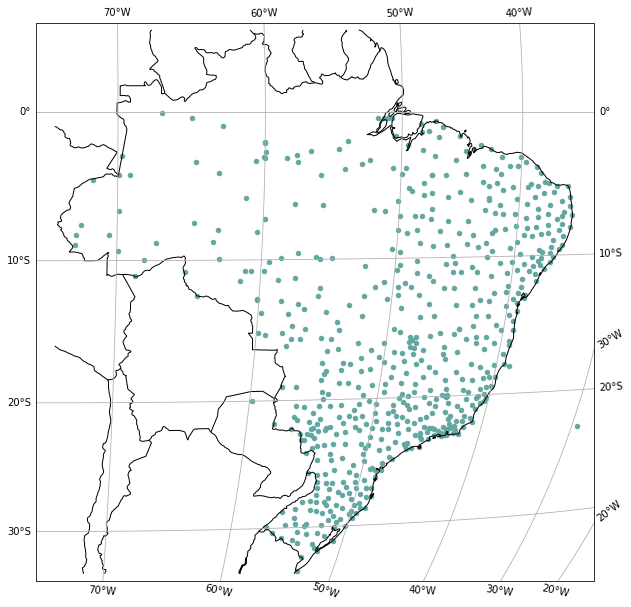

In [15]:
ext_ind_extent = [1344, 2217, 2368, 1193]
projcoords_x, projcoords_y =  plot_dataset_funs.area_def.get_proj_vectors()
ext_area_extent = [projcoords_x[ext_ind_extent[0]], projcoords_y[ext_ind_extent[1]], 
                   projcoords_x[ext_ind_extent[2]], projcoords_y[ext_ind_extent[3]]]

area_def_ext_region = plot_dataset_funs.area_def.copy(area_extent = ext_area_extent,
                                                  height = 1024, 
                                                  width = 1024)
crs = area_def_ext_region.to_cartopy_crs()
fig, ax = plt.subplots(subplot_kw={'projection': crs}, figsize = (10,11))

ax.scatter(x=lonlats_df.lon, y=lonlats_df.lat, transform=ccrs.PlateCarree(), s=20, color='#64a6a1')

ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cartopy.feature.BORDERS)
ax.set_global()
#ax.title.set_text(plot_title)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

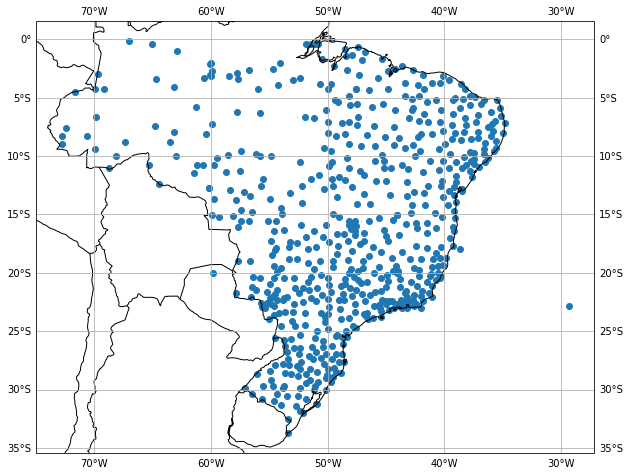

In [53]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize = (10,11))
ax.scatter(x=lonlats_df.lon, y=lonlats_df.lat,  transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.add_feature(cartopy.feature.BORDERS)